# Exercise multimodal recognition: RGB-D scene recognition

This exercise consists of three parts: two tutorials and the deliverable. The students must modify the code of the tutorial part, and write and discuss the results in the deliverable part that will be used to evaluate the exercise.

If you are not familiar with jupyter notebooks please check __[this tutorial](https://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/What%20is%20the%20Jupyter%20Notebook.html)__ first.

# Part 2 (tutorial): RGB-D baseline

If you haven followed the tutorial related with single modality, please run **single.ipynb** first for the first part.

In this tutorial, you will build a two-branch RGB-D network using PyTorch. The code is loosely based on the __[PyTorch transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)__. Just execute the code sequentially, paying attention to the comments.

In [34]:
from __future__ import print_function, division

import copy
import itertools
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader

from utils import STD_RGB, STD_DEPTH, MEAN_RGB, MEAN_DEPTH, Compose, CenterCrop, Resize, ToTensor, RandomResizedCrop, \
    RandomHorizontalFlip, Normalize, ImageFolder, imshow_rgb_d

plt.ion()  # interactive mode


Load Data
---------

We will use torchvision, torch.utils.data and RGBDutils packages for loading the
data. The dataset is structured hierarchically in splits\modalities\classes (check the folder).

In [35]:
# Data augmentation and normalization for training

data_transforms = {
    'train': Compose([
        RandomResizedCrop(227),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(MEAN_RGB, STD_RGB, MEAN_DEPTH, STD_DEPTH)]),
    'val': Compose([
        Resize(256),
        CenterCrop(227),
        ToTensor(),
        Normalize(MEAN_RGB, STD_RGB, MEAN_DEPTH, STD_DEPTH)]),
    'test': Compose([
        Resize(256),
        CenterCrop(227),
        ToTensor(),
        Normalize(MEAN_RGB, STD_RGB, MEAN_DEPTH, STD_DEPTH)]),
}

# Path to the dataset
data_dir = '/home/mcv/datasets/sunrgbd_lite'

# Preparing dataset and dataloaders
partitions = ['train', 'val', 'test']
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in partitions}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in partitions}
dataset_sizes = {x: len(image_datasets[x]) for x in partitions}
class_names = image_datasets['train'].classes

use_gpu = cuda.is_available()


In [36]:
image_datasets


{'test': Dataset ImageFolder
     Number of datapoints: 1587
     Root Location: /home/mcv/datasets/sunrgbd_lite/test,
 'train': Dataset ImageFolder
     Number of datapoints: 745
     Root Location: /home/mcv/datasets/sunrgbd_lite/train,
 'val': Dataset ImageFolder
     Number of datapoints: 868
     Root Location: /home/mcv/datasets/sunrgbd_lite/val}

**Visualize a few samples**

Let's visualize a few RGB-D pairs so as to RGB-D data and data augmentations.



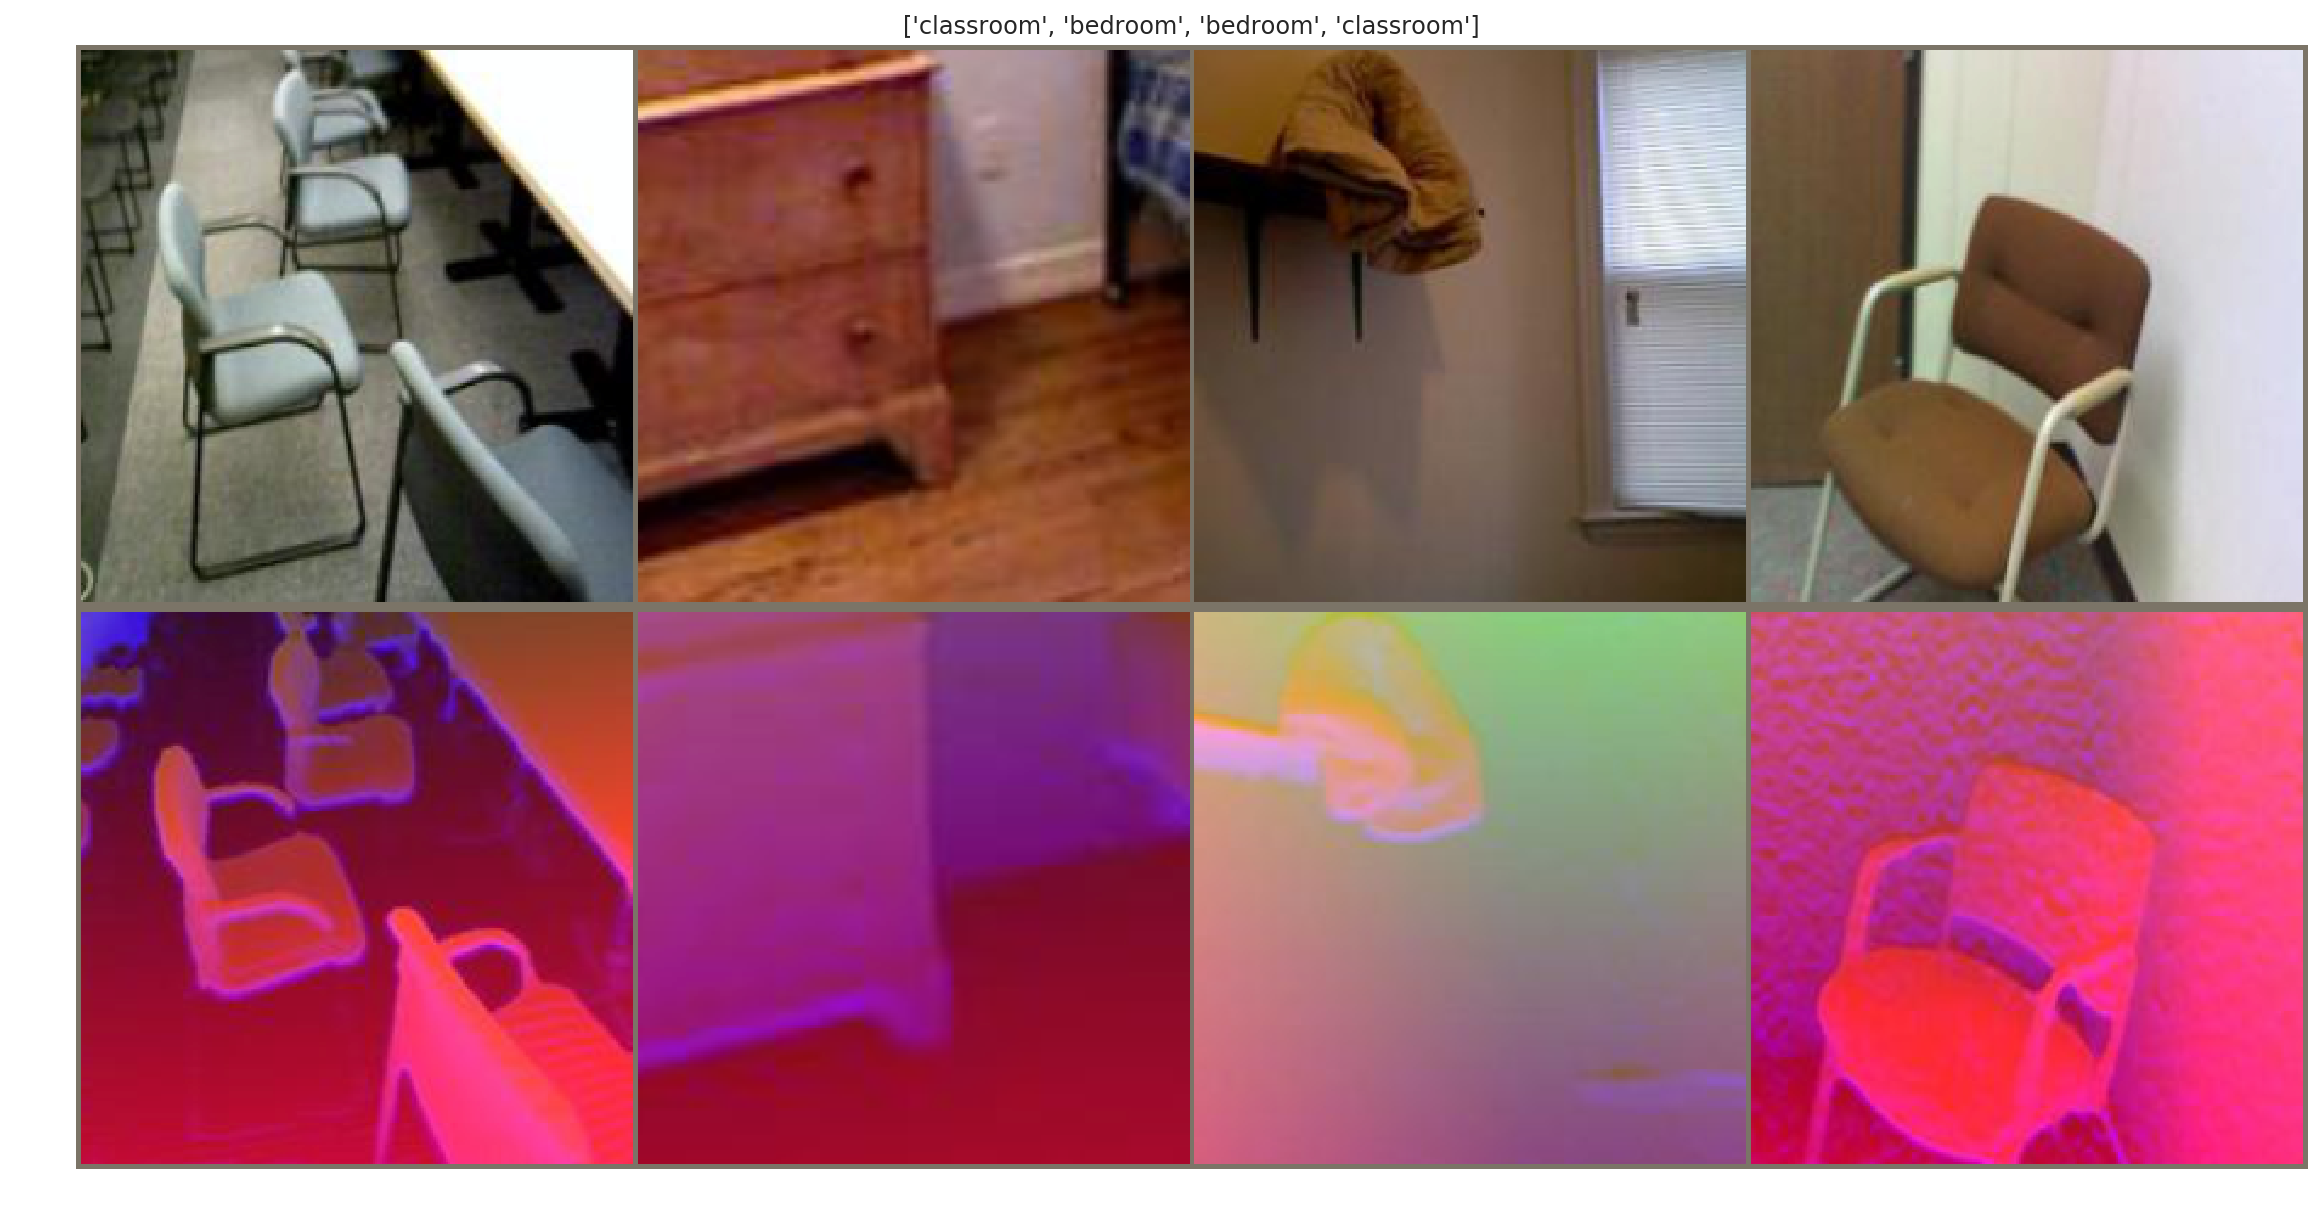

In [37]:
# Get a batch of training data and visualize the first four pairs
inputsRGB, inputsDepth, classes = next(iter(dataloaders['train']))
inputsRGB, inputsDepth, classes = inputsRGB[0:4], inputsDepth[0:4], classes[0:4]

# Make a grid from batch
outRGB = torchvision.utils.make_grid(inputsRGB)
outDepth = torchvision.utils.make_grid(inputsDepth)

imshow_rgb_d(outRGB, outDepth, title=[class_names[x] for x in classes], concat_vert=True)


Training the model
------------------

Now, let's write a general function to train a model. Details:

-  Uses Adam algorithm for gradient descent.
-  Early stoping using best validation accuracy

In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print('Phase %s' % phase)
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs_rgb, inputs_hha, labels = data
                # wrap them in Variable
                if use_gpu:
                    inputs_rgb = Variable(inputs_rgb.cuda())
                    inputs_hha = Variable(inputs_hha.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model((inputs_rgb, inputs_hha))
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                # running_loss += loss.data[0] * inputs_rgb.size(0) # Pytorch 0.4
                running_loss += loss.data.item() * inputs_rgb.size(0)  # Pytorch 1.0
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


And now, a function to evaluate the model on a particular set.

In [39]:
def evaluate_model(model, partition, criterion):
    since = time.time()

    model.train(False)  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for data in dataloaders[partition]:
        # get the inputs
        inputs_rgb, inputs_hha, labels = data
        # wrap them in Variable
        if use_gpu:
            inputs_rgb = Variable(inputs_rgb.cuda())
            inputs_hha = Variable(inputs_hha.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs_rgb, inputs_hha, labels = Variable(inputs_hha), Variable(inputs_hha), Variable(labels)

        # forward
        outputs = model((inputs_rgb, inputs_hha))
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # statistics
        # running_loss += loss.data[0] * inputs_rgb.size(0) # Pytorch 0.4
        running_loss += loss.data.item() * inputs_rgb.size(0)  # Pytorch 1.0
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes[partition]
    test_acc = running_corrects.float() / dataset_sizes[partition]

    print()

    time_elapsed = time.time() - since
    print('Tested in {:.0f}m {:.0f}s Loss: {:.4f} Acc: {:.4f}'.format(
        time_elapsed // 60, time_elapsed % 60, test_loss, test_acc))

    return test_acc, test_loss


Building the RGB-D model
----------------------

The architecture of the network is shown in the following figure:
<img src="figures/rgbd_network.png" />

The following code creates the RGB-D network by instantiating two AlexNets, that are combined using concatenation just before the classifier. There are some tricky steps due to the way the pretrained AlexNet is implemented in PyTorch. 


In [40]:
# In PyTorch every network is implementd as a nn.Module
class RGBDnet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, num_classes):
        super(RGBDnet, self).__init__()

        # RGB branch
        model_rgb = torchvision.models.alexnet(pretrained=True)
        self.rgb_convs = model_rgb.features
        c = model_rgb.classifier
        self.rgb_fcs = nn.Sequential(c[0], c[1], c[2], c[3], c[4], c[5])
        num_ftrs_rgb = c[4].out_features

        # HHA branch
        model_hha = torchvision.models.alexnet(pretrained=True)
        self.hha_convs = model_hha.features
        c = model_hha.classifier
        self.hha_fcs = nn.Sequential(c[0], c[1], c[2], c[3], c[4], c[5])
        f = model_hha.features
        c = model_hha.classifier
        num_ftrs_hha = c[4].out_features

        # Classifier
        self.classifier = nn.Linear(num_ftrs_rgb + num_ftrs_hha, num_classes)

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
        x_rgb = self.rgb_convs(x[0])
        x_rgb = x_rgb.view(x_rgb.size(0), 256 * 6 * 6)
        x_hha = self.hha_convs(x[1])
        x_hha = x_hha.view(x_hha.size(0), 256 * 6 * 6)
        x_rgb = self.rgb_fcs(x_rgb)
        x_hha = self.hha_fcs(x_hha)
        x = torch.cat((x_rgb, x_hha), 1)
        x = self.classifier(x)
        return x


In [ ]:
# Instantiate the model
num_classes = len(class_names)
model = RGBDnet(num_classes=num_classes)

# You can visualize the resulting network
#print(model)


Set up the training/fine tuning parameters
----------------------

The following code creates the optimization criterio and set per-layer training rates to better control the fine tuning and training process. We use a very simple model in which all layers are frozen except the last fully connected one, i.e. the classifier, so it should be easy to improve the performance.

In [42]:
# Here we define the learning rate
for param in model.parameters():  # Freeze all parameters by default
    param.requires_grad = False

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

perlayer_optim = [
    {'params': model.rgb_convs[0].parameters(), 'lr': 0.00},  # conv1 RGB
    {'params': model.rgb_convs[3].parameters(), 'lr': 0.00},  # conv2 RGB
    {'params': model.rgb_convs[6].parameters(), 'lr': 0.00},  # conv3 RGB
    {'params': model.rgb_convs[8].parameters(), 'lr': 0.00},  # conv4 RGB
    {'params': model.rgb_convs[10].parameters(), 'lr': 0.00},  # conv5 RGB
    {'params': model.rgb_fcs[1].parameters(), 'lr': 0.00},  # fc6 RGB
    {'params': model.rgb_fcs[4].parameters(), 'lr': 0.00},  # fc7 RGB
    {'params': model.hha_convs[0].parameters(), 'lr': 0.00},  # conv1 HHA
    {'params': model.hha_convs[3].parameters(), 'lr': 0.00},  # conv2 HHA
    {'params': model.hha_convs[6].parameters(), 'lr': 0.00},  # conv3 HHA
    {'params': model.hha_convs[8].parameters(), 'lr': 0.00},  # conv4 HHA
    {'params': model.hha_convs[10].parameters(), 'lr': 0.00},  # conv5 HHA
    {'params': model.hha_fcs[1].parameters(), 'lr': 0.00},  # fc6 HHA
    {'params': model.hha_fcs[4].parameters(), 'lr': 0.00},  # fc7 HHA
    {'params': model.classifier.parameters(), 'lr': 0.001}  # fc8
]
for param in itertools.chain(model.rgb_convs[0].parameters(), model.rgb_convs[3].parameters(),
                             model.rgb_convs[6].parameters(), model.rgb_convs[8].parameters(),
                             model.rgb_convs[10].parameters(), model.rgb_fcs[1].parameters(),
                             model.rgb_fcs[4].parameters(),
                             model.hha_convs[0].parameters(), model.hha_convs[3].parameters(),
                             model.hha_convs[6].parameters(), model.hha_convs[8].parameters(),
                             model.hha_convs[10].parameters(), model.hha_fcs[1].parameters(),
                             model.hha_fcs[4].parameters(),
                             model.classifier.parameters()):
    param.requires_grad = True

optimizer = Adam(perlayer_optim, lr=learning_rate)


Train and evaluate the model
-----------------

It shouldn't take more than 2 mins to train with the GPU in the server.

In [ ]:
# Train
model = train_model(model, criterion, optimizer, None, num_epochs=25)

# Evaluate
train_acc, _ = evaluate_model(model, 'train', criterion)
val_acc, _ = evaluate_model(model, 'val', criterion)
test_acc, _ = evaluate_model(model, 'test', criterion)
print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' %
      (train_acc * 100, val_acc * 100, test_acc * 100))


# Part 2 (deliverable)

This part will be evaluated as deliverable. Please check you include the required results and information. In principle I don't intent to run your code, just check your numbers and descriptions.

* Comparison of RGB, HHA and RGB-D baselines. Include a table with the train, validation and test average accuracies (and standard deviations) over 5 runs for each case (RGB only, HHA only and RGB-D).
* Description of the improvements of the RGB-D network, experimental results and discussion (0.25 points)
* Team work: description of the contribution of each member of the team.

The maximum of the exercise is 0.5 points.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_format = 'retina'

# Results:

As we can see on the next table and figure, the results on the AlexNet case are much better for the RGB-D, as we have fed rgb and depth information about the environment into the model . On train, the performance is only slightly better (1%) but on test the accuracy improves from 70% ± 1.7% to 74% ± 1.3% with a maximum in 76.24%.  

In order to improve the network, we tried to replace the initial classification system by replacing the outdated AlexNet with some more modern alternatives, such as DenseNet121 and ResNet18. Using these networks, we had a better performance of DenseNet on the validation set (85% ± 0.7% against 80% ± 0.9%) whereas the test results were very similar (77.7% ± 1.3% against 78.2% ± 0.8%). Nevertheless, both results outperform the accuracy of AlexNet.

Of our team, Alba, Pablo and Jorge worked together in all the parts of the development, from setting up the system to improving the network.

CNN   AlexNet                                                               \
Mode      RGB                      HHA                    RGB-D              
Phase   Train Validation   Test  Train Validation   Test  Train Validation   
mean    92.05      77.37  70.78  76.72      64.93  58.60  93.34      80.32   
std      1.80       0.66   1.68   1.46       0.55   2.19   1.72       0.88   

CNN          ResNet                   DenseNet                    
Mode          RGB-D                      RGB-D                    
Phase   Test  Train Validation   Test    Train Validation   Test  
mean   74.48  90.95      83.23  78.16    93.37      85.81  77.69  
std     1.31   2.25       0.85   0.82     0.69       0.67   1.29

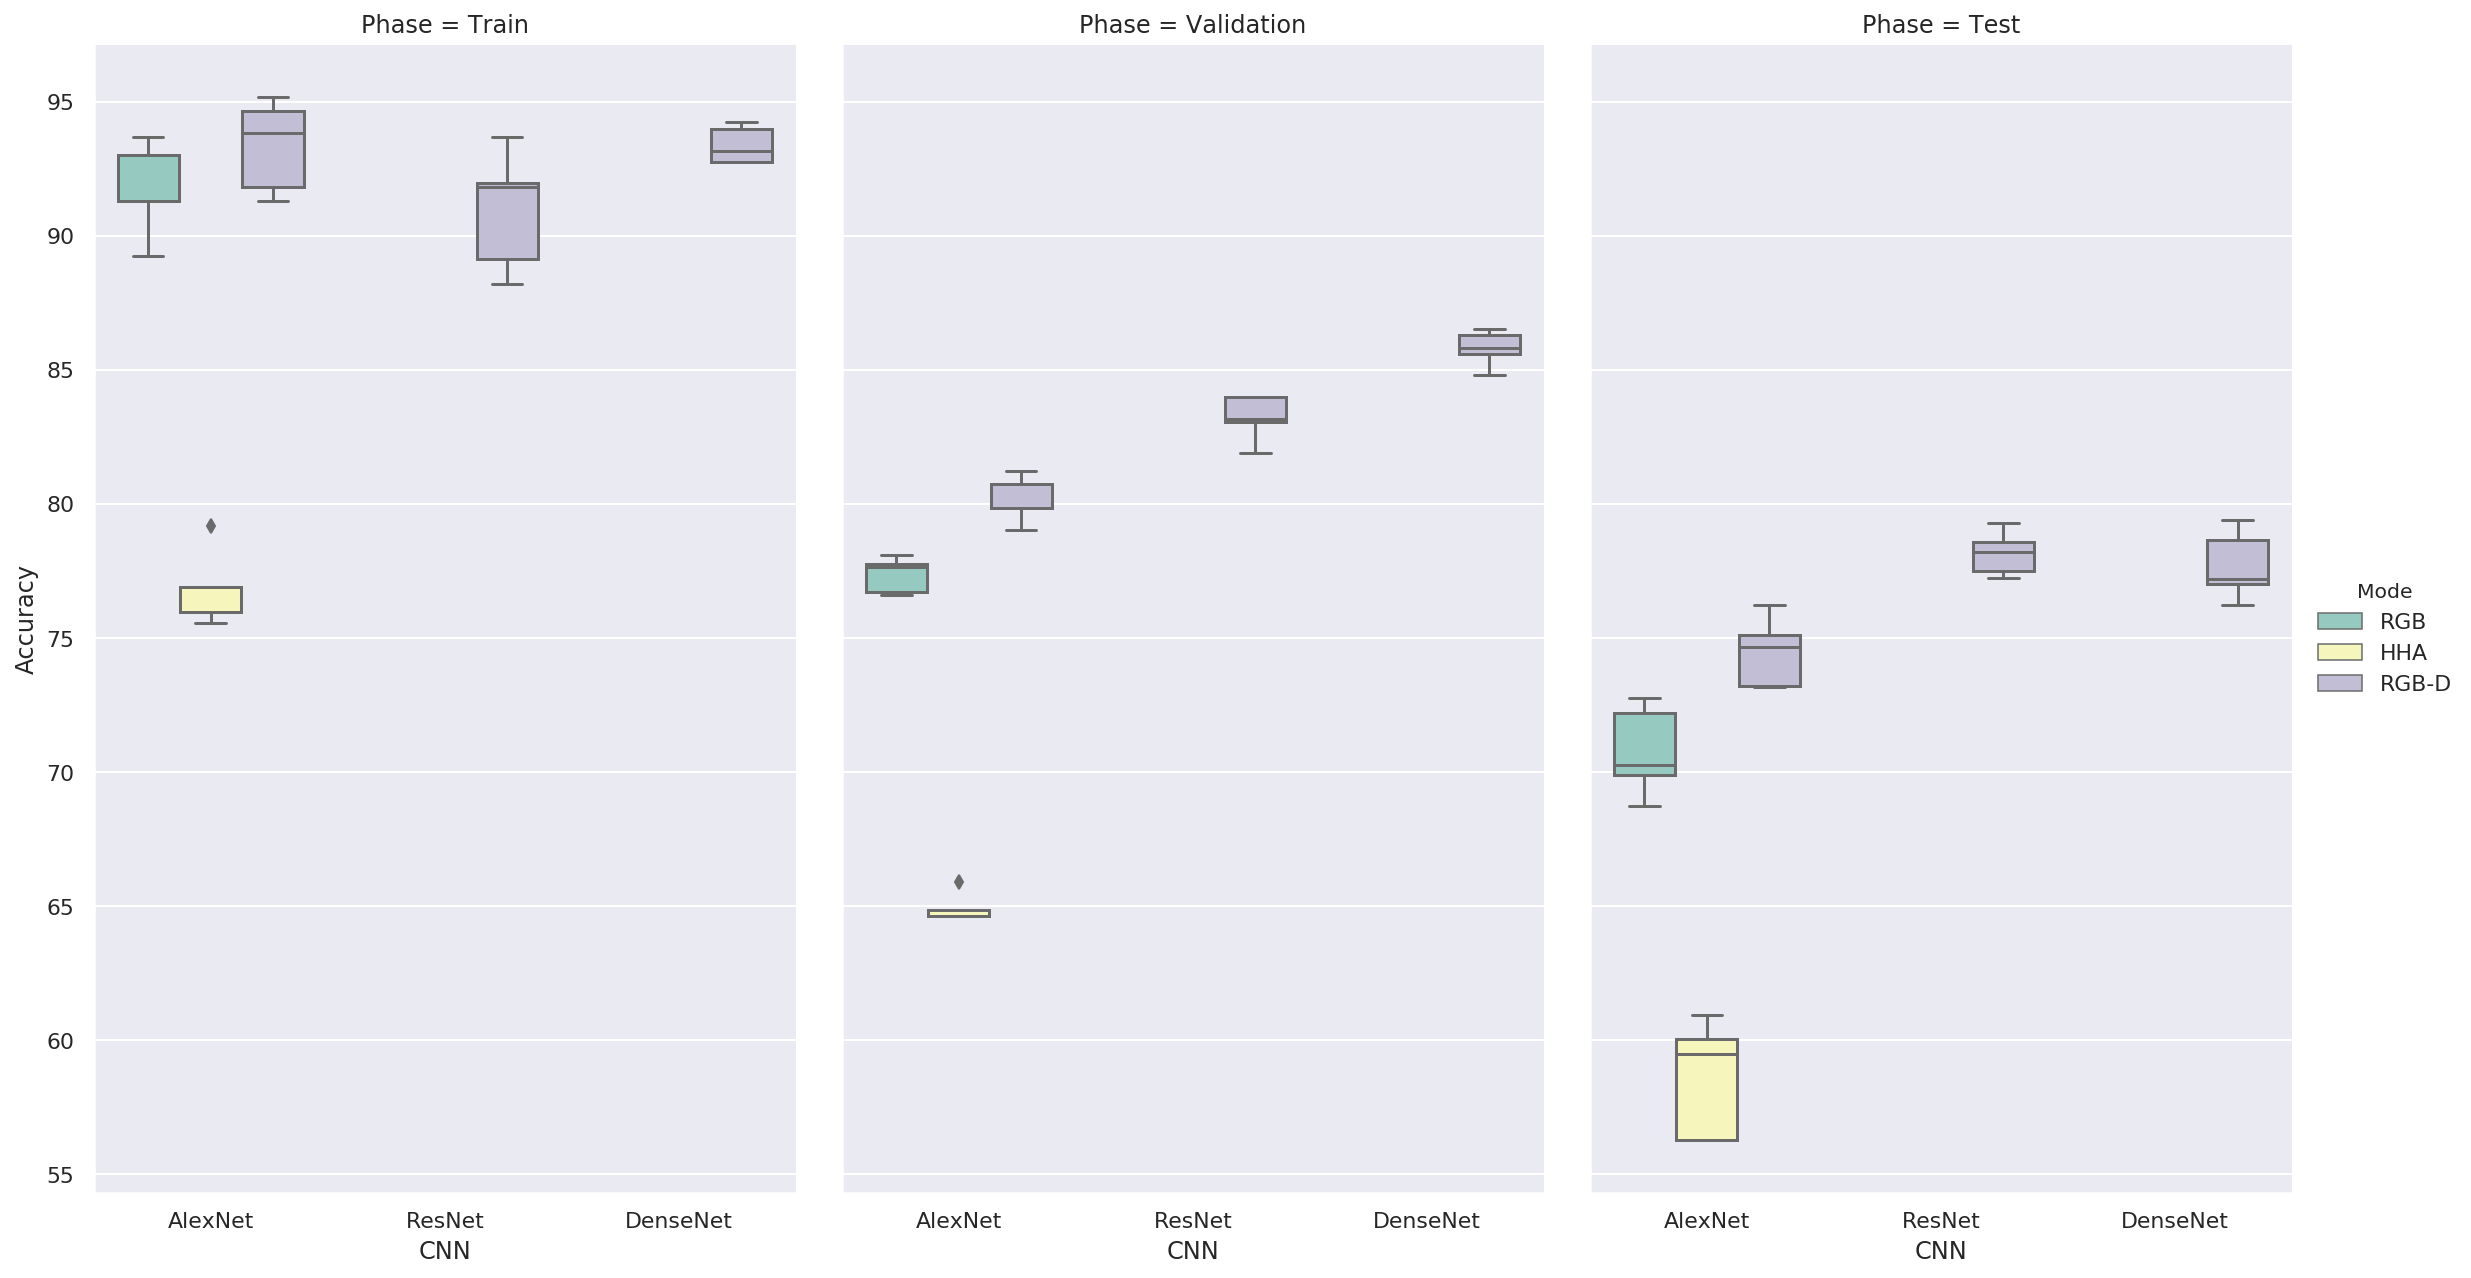

In [69]:
df, df_full = show_results()
df.transpose()


In [71]:
# All results
df_full

,Accuracy,CNN,Mode,Phase
0,91.280000,AlexNet,RGB,Train
1,89.260000,AlexNet,RGB,Train
2,93.020000,AlexNet,RGB,Train
3,93.690000,AlexNet,RGB,Train
4,93.020000,AlexNet,RGB,Train
5,76.910000,AlexNet,HHA,Train
6,75.970000,AlexNet,HHA,Train
7,75.570000,AlexNet,HHA,Train
8,79.190000,AlexNet,HHA,Train
9,75.970000,AlexNet,HHA,Train


# ResNet

In [58]:
# In PyTorch every network is implementd as a nn.Module
class RGBDnet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, num_classes):
        super(RGBDnet, self).__init__()

        # RGB branch
        self.model_rgb = torchvision.models.resnet18(pretrained=True)
        for param in self.model_rgb.parameters():
            param.requires_grad = False
        
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.model_rgb.fc.in_features
        self.model_rgb.fc = nn.Linear(num_ftrs, num_ftrs)

        # HHA branch
        self.model_hha = torchvision.models.resnet18(pretrained=True)
        for param in self.model_hha.parameters():
            param.requires_grad = False
        
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.model_hha.fc.in_features
        self.model_hha.fc = nn.Linear(num_ftrs, num_ftrs)

        # Classifier
        self.classifier = nn.Linear(2 * num_ftrs, num_classes)

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
        x_rgb = self.model_rgb(x[0])
        x_hha = self.model_hha(x[1])
        x = torch.cat((x_rgb, x_hha), 1)
        x = self.classifier(x)
        return x


In [59]:
# Instantiate the model
num_classes = len(class_names)
model = RGBDnet(num_classes=num_classes)

# You can visualize the resulting network
#print(model)


In [60]:
# Here we define the learning rate

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = Adam(model.parameters(), lr=learning_rate)


In [61]:
train_resnet = []
val_resnet = []
test_resnet = []

for i in range(5):
    # Train
    model = train_model(model, criterion, optimizer, None, num_epochs=25)

    # Evaluate
    train_acc, _ = evaluate_model(model, 'train', criterion)
    val_acc, _ = evaluate_model(model, 'val', criterion)
    test_acc, _ = evaluate_model(model, 'test', criterion)
    print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' %
          (train_acc * 100, val_acc * 100, test_acc * 100))
    
    train_resnet.append(float(train_acc * 100))
    val_resnet.append(float(val_acc * 100))
    test_resnet.append(float(test_acc * 100))


Epoch 0/24
----------
Phase train
train Loss: 1.8235 Acc: 0.4201
Phase val
val Loss: 1.1350 Acc: 0.6048

Epoch 1/24
----------
Phase train
train Loss: 0.8303 Acc: 0.7034
Phase val
val Loss: 0.7748 Acc: 0.7212

Epoch 2/24
----------
Phase train
train Loss: 0.7324 Acc: 0.7423
Phase val
val Loss: 0.6682 Acc: 0.7903

Epoch 3/24
----------
Phase train
train Loss: 0.7386 Acc: 0.7289
Phase val
val Loss: 0.5771 Acc: 0.8191

Epoch 4/24
----------
Phase train
train Loss: 0.6341 Acc: 0.7705
Phase val
val Loss: 0.7384 Acc: 0.7293

Epoch 5/24
----------
Phase train
train Loss: 0.5247 Acc: 0.7973
Phase val
val Loss: 0.5661 Acc: 0.7949

Epoch 6/24
----------
Phase train
train Loss: 0.4825 Acc: 0.8121
Phase val
val Loss: 0.5883 Acc: 0.8018

Epoch 7/24
----------
Phase train
train Loss: 0.4317 Acc: 0.8483
Phase val
val Loss: 0.5365 Acc: 0.8306

Epoch 8/24
----------
Phase train
train Loss: 0.4046 Acc: 0.8416
Phase val
val Loss: 0.5198 Acc: 0.8065

Epoch 9/24
----------
Phase train
train Loss: 0.3939 Ac

train Loss: 0.2875 Acc: 0.9087
Phase val
val Loss: 0.6099 Acc: 0.8030

Epoch 24/24
----------
Phase train
train Loss: 0.3201 Acc: 0.8738
Phase val
val Loss: 0.5867 Acc: 0.8111

Training complete in 3m 32s
Best val Acc: 0.830645

Tested in 0m 4s Loss: 0.2327 Acc: 0.9181

Tested in 0m 4s Loss: 0.6017 Acc: 0.8306

Tested in 0m 7s Loss: 0.8621 Acc: 0.7725
Accuracy. Train: 91.81% val: 83.06% test: 77.25%
Epoch 0/24
----------
Phase train
train Loss: 0.3115 Acc: 0.8899
Phase val
val Loss: 0.5971 Acc: 0.8249

Epoch 1/24
----------
Phase train
train Loss: 0.2549 Acc: 0.8980
Phase val
val Loss: 0.6255 Acc: 0.8318

Epoch 2/24
----------
Phase train
train Loss: 0.3488 Acc: 0.8792
Phase val
val Loss: 0.6249 Acc: 0.8018

Epoch 3/24
----------
Phase train
train Loss: 0.2733 Acc: 0.8980
Phase val
val Loss: 0.7112 Acc: 0.7650

Epoch 4/24
----------
Phase train
train Loss: 0.2929 Acc: 0.8966
Phase val
val Loss: 0.8831 Acc: 0.7074

Epoch 5/24
----------
Phase train
train Loss: 0.2984 Acc: 0.8872
Phase v

# DenseNet

In [43]:
# In PyTorch every network is implementd as a nn.Module
class RGBDnet(nn.Module):
    # The parameters are initialized in __init__(self, ...)
    def __init__(self, num_classes):
        super(RGBDnet, self).__init__()

        # RGB branch
        self.model_rgb = torchvision.models.densenet121(pretrained=True)
        for param in self.model_rgb.parameters():
            param.requires_grad = False
        
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.model_rgb.classifier.in_features
        self.model_rgb.classifier = nn.Linear(num_ftrs, num_ftrs)

        # HHA branch
        self.model_hha = torchvision.models.densenet121(pretrained=True)
        for param in self.model_hha.parameters():
            param.requires_grad = False
        
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = self.model_hha.classifier.in_features
        self.model_hha.classifier = nn.Linear(num_ftrs, num_ftrs)

        # Classifier
        self.classifier = nn.Linear(2 * num_ftrs, num_classes)

    # The data flow is defined in forward. No need to specify backward operations (PyTorch takes care of them)
    def forward(self, x):
        x_rgb = self.model_rgb(x[0])
        x_hha = self.model_hha(x[1])
        x = torch.cat((x_rgb, x_hha), 1)
        x = self.classifier(x)
        return x

In [44]:
# Instantiate the model
num_classes = len(class_names)
model = RGBDnet(num_classes=num_classes)

# You can visualize the resulting network
#print(model)

In [45]:
# Here we define the learning rate

if use_gpu:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = Adam(model.parameters(), lr=learning_rate)


In [52]:
train_densenet = []
val_densenet = []
test_densenet = []

for i in range(5):
    # Train
    model = train_model(model, criterion, optimizer, None, num_epochs=25)

    # Evaluate
    train_acc, _ = evaluate_model(model, 'train', criterion)
    val_acc, _ = evaluate_model(model, 'val', criterion)
    test_acc, _ = evaluate_model(model, 'test', criterion)
    print('Accuracy. Train: %1.2f%% val: %1.2f%% test: %1.2f%%' %
          (train_acc * 100, val_acc * 100, test_acc * 100))
    
    train_densenet.append(float(train_acc * 100))
    val_densenet.append(float(val_acc * 100))
    test_densenet.append(float(test_acc * 100))
    


Epoch 0/24
----------
Phase train
train Loss: 0.2208 Acc: 0.9060
Phase val
val Loss: 0.7918 Acc: 0.7995

Epoch 1/24
----------
Phase train
train Loss: 0.2220 Acc: 0.9195
Phase val
val Loss: 0.9846 Acc: 0.7719

Epoch 2/24
----------
Phase train
train Loss: 0.2503 Acc: 0.9020
Phase val
val Loss: 0.7661 Acc: 0.8491

Epoch 3/24
----------
Phase train
train Loss: 0.2036 Acc: 0.9221
Phase val
val Loss: 0.7237 Acc: 0.8341

Epoch 4/24
----------
Phase train
train Loss: 0.2532 Acc: 0.9101
Phase val
val Loss: 0.7118 Acc: 0.8537

Epoch 5/24
----------
Phase train
train Loss: 0.2694 Acc: 0.9047
Phase val
val Loss: 0.9307 Acc: 0.7765

Epoch 6/24
----------
Phase train
train Loss: 0.3359 Acc: 0.8832
Phase val
val Loss: 0.8507 Acc: 0.8007

Epoch 7/24
----------
Phase train
train Loss: 0.2335 Acc: 0.9114
Phase val
val Loss: 0.9229 Acc: 0.7765

Epoch 8/24
----------
Phase train
train Loss: 0.2684 Acc: 0.8993
Phase val
val Loss: 0.8848 Acc: 0.7834

Epoch 9/24
----------
Phase train
train Loss: 0.3148 Ac

train Loss: 0.2568 Acc: 0.9087
Phase val
val Loss: 0.7594 Acc: 0.8341

Epoch 24/24
----------
Phase train
train Loss: 0.1916 Acc: 0.9383
Phase val
val Loss: 0.7221 Acc: 0.8111

Training complete in 4m 26s
Best val Acc: 0.847926

Tested in 0m 5s Loss: 0.2062 Acc: 0.9275

Tested in 0m 6s Loss: 0.6130 Acc: 0.8479

Tested in 0m 11s Loss: 0.9103 Acc: 0.7700
Accuracy. Train: 92.75% val: 84.79% test: 77.00%
Epoch 0/24
----------
Phase train
train Loss: 0.2755 Acc: 0.9034
Phase val
val Loss: 0.7203 Acc: 0.8364

Epoch 1/24
----------
Phase train
train Loss: 0.2294 Acc: 0.9128
Phase val
val Loss: 0.7349 Acc: 0.8445

Epoch 2/24
----------
Phase train
train Loss: 0.3209 Acc: 0.8953
Phase val
val Loss: 0.6170 Acc: 0.8491

Epoch 3/24
----------
Phase train
train Loss: 0.3292 Acc: 0.8899
Phase val
val Loss: 0.6659 Acc: 0.8422

Epoch 4/24
----------
Phase train
train Loss: 0.2622 Acc: 0.9020
Phase val
val Loss: 0.7030 Acc: 0.8548

Epoch 5/24
----------
Phase train
train Loss: 0.2321 Acc: 0.9128
Phase 

# Show results

In [68]:
def show_results():
    # AlexNet
    train = rgb_train + hha_train + multi_train
    val = rgb_val + hha_val + multi_val
    test = rgb_test + hha_test + multi_test
    values_alexnet = train + val + test
    network_alexnet = ['AlexNet'] * 45

    fase_alexnet = ['Train'] * 15 + ['Validation'] * 15 + ['Test'] * 15
    labels = ['RGB'] * 5 +  ['HHA'] * 5 + ['RGB-D'] * 5
    labels_alexnet = labels * 3
    
    # ResNet
    values_resnet = train_resnet + val_resnet + test_resnet
    network_resnet = ['ResNet'] * 15

    fase_resnet = ['Train'] * 5 + ['Validation'] * 5 + ['Test'] * 5
    labels_resnet = ['RGB-D'] * 15
    
    # DenseNet 
    values_densenet = train_densenet + val_densenet + test_densenet
    network_densenet = ['DenseNet'] * 15

    fase_densenet = ['Train'] * 5 + ['Validation'] * 5 + ['Test'] * 5
    labels_densenet = ['RGB-D'] * 15
    
    # Merge in Dataframe
    values = values_alexnet + values_resnet + values_densenet
    fase_pd = fase_alexnet + fase_resnet + fase_densenet
    labels_pd = labels_alexnet + labels_resnet + labels_densenet
    network = network_alexnet + network_resnet + network_densenet
    df = pd.DataFrame({'Accuracy': values, 'Phase': fase_pd, 'Mode': labels_pd, 'CNN': network})
    df1 = df.groupby(['CNN', 'Mode', 'Phase'], as_index=True, sort=False).describe()
    df2 = df1 ['Accuracy']
    df3 = df2 [['mean','std']]
    
    # Plot
    plt.rcParams['figure.figsize'] = [20.0,20.0]
    
    #ax = sns.catplot(x="Phase", y="Accuracy", hue="Mode", col='CNN', data=df, palette="Set3", kind="box", height=7, aspect=0.7)
    ax = sns.catplot(x="CNN", y="Accuracy", hue="Mode", col='Phase', data=df, palette="Set3", kind="box", height=9, aspect=0.6)

    return df3.round(2), df

In [48]:
# Results
rgb_train = [91.28, 89.26, 93.02, 93.69, 93.02]
rgb_val = [76.61, 77.65, 76.73, 77.76, 78.11]
rgb_test = [69.88, 72.78, 68.75, 70.26, 72.21]

hha_train = [76.91, 75.97, 75.57, 79.19, 75.97]
hha_val = [64.86, 64.63, 64.63, 65.90, 64.63]
hha_test = [60.93, 56.27, 60.05, 59.48, 56.27]

multi_train = [91.81, 91.28, 93.83, 94.63, 95.17]
multi_val = [80.76, 80.76, 79.84, 79.03, 81.22]
multi_test = [76.24, 73.16, 74.67, 73.22, 75.11]

#train_resnet = [89.53, 90.07, 90.87, 90.47, 93.15]
#val_resnet = [82.14, 82.14, 83.41, 82.60, 82.26]
#test_resnet = [76.81, 78.32, 79.27, 77.82, 78.07]

#train_densenet = [91.81, 91.54, 92.89, 95.44, 94.63]
#val_densenet = [85.71, 86.64, 85.60, 85.48, 85.60]
#test_densenet = [79.96, 78.95, 77.82, 79.02, 78.89]